In [1]:
# Explore trends in route and vehicle allocations

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import glob
import datetime as dt
import global_variables as gv
import matplotlib.dates as mdates

In [2]:
# Load different allocation data
load_columns = [
    'Route_ID','Branch_ID','Start_Time_of_Route','End_Time_of_Route',
    'Loaded_Kgs','Energy_Required','vannumber_ev_','vannumber_d_']
chargers = [7,22,45] 
journeys ={}
for c in chargers:
    filepath = r'Inputs/JPL_allocation/Vivaro_allstores_{}kW/*.csv'.format(c)
    all_files = glob.glob(filepath)
    journeys_list = []
    # for f in all_files:
    #     journeys_list.append(pd.read_csv(f,usecols=load_columns))
    journeys[c] = pd.concat(
        (pd.read_csv(f,usecols = load_columns) for f in all_files))
    journeys[c]['Start_dt']=pd.to_datetime(
        journeys[c]['Start_Time_of_Route'])
    print('Start_dt')
    journeys[c]['End_dt']=pd.to_datetime(
        journeys[c]['End_Time_of_Route'])
    print('End_dt')
    journeys[c]['date'] = journeys[c]['Start_dt'].dt.date
    journeys[c]['Start_t'] = journeys[c]['Start_dt'].dt.time
    journeys[c]['Start_t'] = pd.to_datetime(
        '2019-01-01 ' + journeys[c]['Start_t'].astype(str))
    journeys[c]['End_t'] = journeys[c]['End_dt'].dt.time
    journeys[c]['End_t'] = pd.to_datetime(
        '2019-01-01 ' + journeys[c]['End_t'].astype(str))
    journeys[c]['Charger'] = c
    print('set charger')
    journeys[c].rename(columns={
        'vannumber_ev_':'Vehicle_ID',
        'vannumber_d_':'Diesel_ID'},
        inplace=True)
    journeys[c].drop(
        columns=['Start_Time_of_Route','End_Time_of_Route'],
        inplace=True
    )
    journeys[c].set_index(['Branch_ID','Vehicle_ID','Diesel_ID','Route_ID'],inplace=True)
    journeys[c].to_csv('Outputs/Journey_stats/journeys{}.csv'.format(c))

Start_dt
End_dt
set charger
Start_dt
End_dt
set charger
Start_dt
End_dt
set charger


In [12]:
# Make arrival / departure histograms. Look at inter-shift time
describe_all = []

for c in chargers:
    desc = journeys[c].describe()
    desc['Charger'] = c
    desc['Vehicle_Type'] = 'all'
    describe_all.append(desc)
    desc = journeys[c].loc[(slice(None),0,slice(None)),:].describe()
    desc['Charger'] = c
    desc['Vehicle_Type'] = 'd'    
    describe_all.append(desc)
    desc = journeys[c].loc[(slice(None),slice(None),0),:].describe()
    desc['Charger'] = c
    desc['Vehicle_Type'] = 'ev'  
    describe_all.append(desc)

desc_df = pd.concat(describe_all)
desc_df = desc_df.set_index(['Charger','Vehicle_Type',desc_df.index])

for c in chargers:
    desc_df.loc[(c,'all','max'),'Start_t'] = journeys[c]['Start_t'].max()
    desc_df.loc[(c,'all','max'),'End_t'] = journeys[c]['End_t'].max()
    desc_df.loc[(c,'ev','max'),'Start_t'] = journeys[c].loc[(slice(None),slice(None),0),:]['Start_t'].max()
    desc_df.loc[(c,'ev','max'),'End_t'] = journeys[c].loc[(slice(None),slice(None),0),:]['End_t'].max()
    desc_df.loc[(c,'d','max'),'Start_t'] = journeys[c].loc[(slice(None),0,slice(None)),:]['Start_t'].max()
    desc_df.loc[(c,'d','max'),'End_t'] = journeys[c].loc[(slice(None),0,slice(None)),:]['End_t'].max()
    desc_df.loc[(c,'all','min'),'Start_t'] = journeys[c]['Start_t'].min()
    desc_df.loc[(c,'all','min'),'End_t'] = journeys[c]['End_t'].min()
    desc_df.loc[(c,'ev','min'),'Start_t'] = journeys[c].loc[(slice(None),slice(None),0),:]['Start_t'].min()
    desc_df.loc[(c,'ev','min'),'End_t'] = journeys[c].loc[(slice(None),slice(None),0),:]['End_t'].min()
    desc_df.loc[(c,'d','min'),'Start_t'] = journeys[c].loc[(slice(None),0,slice(None)),:]['Start_t'].min()
    desc_df.loc[(c,'d','min'),'End_t'] = journeys[c].loc[(slice(None),0,slice(None)),:]['End_t'].min()

desc_df.to_csv('Outputs/Journey_stats/desc.csv')

In [8]:
max_time = dt.datetime(2019,1,2,0,0,0)
min_time = dt.datetime(2019,1,1,4,30,0)

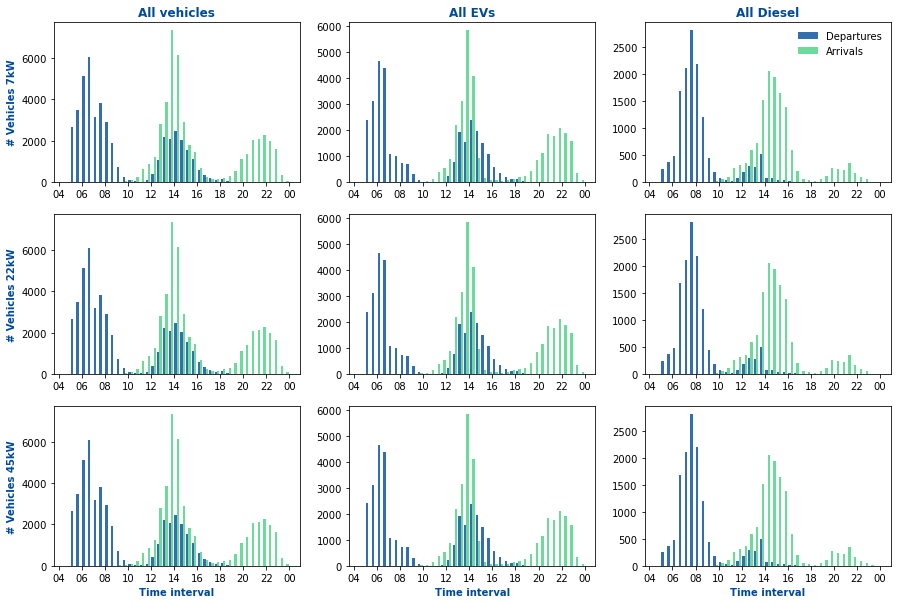

In [9]:
num_bins = int(
    (max_time - min_time).total_seconds() / (gv.TIME_INT.total_seconds()) 
    + 1)
bins_time = [min_time + i * gv.TIME_INT for i in range(num_bins)]
type_dict = {0:'all',1:'ev',2:'d'}

journ = journeys[7]
fig, ax = plt.subplots(
    3,3,
    figsize=(15,10))

for i in range(3):
    journ = journeys[chargers[i]]
    ax[i,0].hist(
        [journ['Start_t'],journ['End_t']] , 
        bins=bins_time,
        color=[gv.FPS_BLUE, gv.FPS_GREEN],
        alpha=0.8,
        label=['Departures','Arrivals']
    )

    ax[i,1].hist(
        [journ[journ['Diesel_ID']==0]['Start_t'],journ[journ['Diesel_ID']==0]['End_t']], 
        bins=bins_time,
        color=[gv.FPS_BLUE, gv.FPS_GREEN],
        alpha=0.8,
        label=['Departures','Arrivals']
    )

    ax[i,2].hist(
        [journ[journ['Vehicle_ID']==0]['Start_t'],journ[journ['Vehicle_ID']==0]['End_t']], 
        bins=bins_time,
        color=[gv.FPS_BLUE, gv.FPS_GREEN],
        alpha=0.8,
        label=['Departures','Arrivals']
    )
    ax[i,0].set_ylabel('# Vehicles {}kW'.format(chargers[i]), color=gv.FPS_BLUE, fontweight='bold')

ax[2,0].set_xlabel('Time interval', color=gv.FPS_BLUE, fontweight='bold')
ax[2,1].set_xlabel('Time interval', color=gv.FPS_BLUE, fontweight='bold')
ax[2,2].set_xlabel('Time interval', color=gv.FPS_BLUE, fontweight='bold')

ax[0,0].set_title('All vehicles', color=gv.FPS_BLUE, fontweight='bold')
ax[0,1].set_title('All EVs', color=gv.FPS_BLUE, fontweight='bold')
ax[0,2].set_title('All Diesel', color=gv.FPS_BLUE, fontweight='bold')
ax[0,2].legend(frameon=False)

for axs in fig.get_axes():
    axs.xaxis.set_major_formatter(mdates.DateFormatter('%H'))
    
plt.show()
fig.savefig('Outputs/Journey_stats/time_hist.svg',
            bbox_inches = "tight")

In [73]:
# Get column for previous arrival time for each van
def get_next_departure(journey):
    vans = list(journey.index.get_level_values('Vehicle_ID').unique())
    if 0 in vans:
        vans.remove(0)
    print(vans)
    van_journeys_list = []
    for van in vans:
        van_journeys = journey.loc[(van,slice(None),slice(None)),:].copy()
        van_journeys.sort_values(
            by=['Start_dt'],
            inplace=True,
            ascending=False)
        next_departure = dt.datetime.combine(
            max(journey['date']),
            dt.datetime.min.time()
        ) + dt.timedelta(days=1, hours=6)
        for idx in van_journeys.index:
            van_journeys.loc[idx, 'Next_Departure'] = next_departure
            next_departure = van_journeys.loc[idx, 'Start_dt']
        van_journeys.sort_values(by=['Start_dt'], inplace=True)
        van_journeys_list.append(van_journeys)
    dvans = list(journey.index.get_level_values('Diesel_ID').unique())
    if 0 in dvans:
        dvans.remove(0)
    print(dvans)
    for van in dvans:
        van_journeys = journey.loc[(slice(None),van,slice(None)),:].copy()
        van_journeys.sort_values(
            by=['Start_dt'],
            inplace=True,
            ascending=False)
        next_departure = dt.datetime.combine(
            max(journey['date']),
            dt.datetime.min.time()
        ) + dt.timedelta(days=1, hours=6)
        for idx in van_journeys.index:
            van_journeys.loc[idx, 'Next_Departure'] = next_departure
            next_departure = van_journeys.loc[idx, 'Start_dt']
        van_journeys.sort_values(by=['Start_dt'], inplace=True)
        van_journeys_list.append(van_journeys)
    return pd.concat(van_journeys_list)

In [77]:
new_journeys ={}
for c in chargers:
    branches = list(journeys[c].index.get_level_values(0).unique())
    branch_journeys = []
    for branch in branches:
        print(c, branch)
        journey = journeys[c].loc[branch]
        journey['Branch_ID'] = branch
        branch_journeys.append(get_next_departure(journey))
    new_journeys[c] =pd.concat(branch_journeys)
    new_journeys[c]['Charging_Time'] = new_journeys[c]['Next_Departure'] - new_journeys[c]['End_dt']

7 211
[1, 2, 3, 4, 5]
[1, 2]
7 213
[1, 2, 3, 4, 5, 6]
[1, 2, 3, 4]
7 513
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45]
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69]
22 211
[1, 2, 3, 4, 5]
[1, 2]
22 213
[1, 2, 3, 4, 5, 6]
[1, 2, 3, 4]
22 513
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45]
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62,

In [112]:


ev_journeys.values

array([ 3601., 43200.,  1681., ..., 56999., 61560., 57060.])

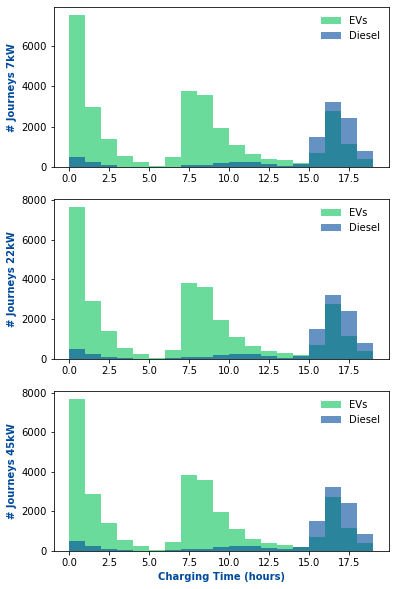

In [163]:
color = {
    7: gv.FPS_YELLOW,  
    22: gv.FPS_BLUE,
    45: gv.FPS_GREEN
 }

fig, ax = plt.subplots(
    3,
    figsize=(6,10))
for i in range(3):
    c=chargers[i]
    ev_journeys = new_journeys[c].loc[(slice(None),0,slice(None)),'Charging_Time'].reset_index(drop=True).dt.total_seconds()
    d_journeys = new_journeys[c].loc[(0,slice(None),slice(None)),'Charging_Time'].reset_index(drop=True).dt.total_seconds()

    ax[i].hist(
        ev_journeys.values/3600,
        color=gv.FPS_GREEN,
        bins=[i for i in range(20)],
        alpha=0.8,
        label='EVs')

    ax[i].hist(
        d_journeys.values/3600,
        color=gv.FPS_BLUE,
        bins=[i for i in range(20)],
        alpha=0.6,
        label='Diesel')

    ax[i].legend(frameon=False)
    ax[i].set_ylabel('# Journeys {}kW'.format(c), color=gv.FPS_BLUE, fontweight='bold')
ax[2].set_xlabel('Charging Time (hours)', color=gv.FPS_BLUE, fontweight='bold')
plt.show()
fig.savefig('Outputs/Journey_stats/charging_time_hist.svg',
            bbox_inches = "tight")

In [157]:
new_journeys[c].loc[(slice(None),0,slice(None)),'Charging_Time'].dt.total_seconds().describe()

count    3.130300e+04
mean     2.865958e+04
std      5.725513e+04
min      6.000000e+01
25%      3.719000e+03
50%      2.772000e+04
75%      3.858000e+04
max      4.993141e+06
Name: Charging_Time, dtype: float64

In [155]:
new_journeys[c].loc[(0,slice(None),slice(None)),'Charging_Time'].dt.total_seconds().describe()

count    1.344300e+04
mean     1.176210e+05
std      3.962848e+05
min      6.000000e+01
25%      5.717900e+04
50%      6.108000e+04
75%      6.839950e+04
max      2.719470e+07
Name: Charging_Time, dtype: float64

In [ ]:
# Compare number of EVs and diesel
# Get statistics at store level, yearlong distribution

In [ ]:
# Get some statistical difference between EV journeys and diesel journeys

In [ ]:
# Look at season, week trends.

In [ ]:
# Any difference between stores